In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import torch

print("GPU Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))

GPU Available: True
GPU Name: Tesla T4


In [2]:
!pip install geopandas
!pip install cython>=0.29.14
!pip install git+https://github.com/jcrudy/choldate.git
!pip install knockpy

  Cloning https://github.com/jcrudy/choldate.git to /tmp/pip-req-build-4nlw8_vp
  Running command git clone --filter=blob:none --quiet https://github.com/jcrudy/choldate.git /tmp/pip-req-build-4nlw8_vp
  Resolved https://github.com/jcrudy/choldate.git to commit 0d92a523f8da083031faa0eb187a7b0f287afe69
  Preparing metadata (setup.py) ... done
  Created wheel for choldate: filename=choldate-0.1.0-cp310-cp310-linux_x86_64.whl size=98539 sha256=e092c18ac9c17ca09b4ccecd7471e2833223a1d83a434655e442b477157ed020
  Stored in directory: /tmp/pip-ephem-wheel-cache-isvkl3ae/wheels/25/4a/48/b3236da795d0f0cb2c7d4c2e6d036c0288e7f3eb18a3468259
Successfully built choldate
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 MB 34.2 MB/s eta 0:00:00:00:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for knockpy: filename=knockpy-1.3.2-cp310-cp310-linux_x86_64.whl size=2455257 sha256=96497f0c

In [4]:
import shap
import numpy as np
import pandas as pd
import xgboost as xgb
import geopandas as gpd
import knockpy.knockoffs as kf
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
import matplotlib.colors as colors
from knockpy import KnockoffFilter
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from knockpy.knockoff_filter import KnockoffFilter
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split, KFold
from sklearn.multioutput import MultiOutputRegressor
from sklearn.inspection import permutation_importance
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [5]:
# CSV files for 2019 and 2020 (use chunks for large files)
chunk_size = 5000
df_2019_chunks = pd.read_csv(r"/kaggle/input/medsat/2019_spatial_raw_master.csv", chunksize=chunk_size)
df_2019 = pd.concat(chunk for chunk in df_2019_chunks)
df_2020_chunks = pd.read_csv(r"/kaggle/input/medsat/2020_spatial_raw_master.csv", chunksize=chunk_size)
df_2020 = pd.concat(chunk for chunk in df_2020_chunks)

# Add year column for temporal analysis
df_2019['year'] = 2019
df_2020['year'] = 2020
df = pd.concat([df_2019, df_2020])

In [6]:
df.shape

(67510, 169)

In [8]:
print("Column names:")
print(df.columns.tolist())

Column names:
['geography code', 'LSOA21NM', 'geometry', 'centroid_x', 'centroid_y', 'c_percent asian', 'c_percent black', 'c_percent mixed', 'c_percent white', 'c_percent sikh', 'c_percent hindu', 'c_percent christian', 'c_percent jewish', 'c_percent buddhist', 'c_percent no religion', 'c_percent muslim', 'c_percent no central heating', 'c_percent wood heating', 'c_percent communal heating', 'c_percent TFW less than 2km', 'c_percent TFW 2km to 5km', 'c_percent TFW 60km and over', 'c_percent WFH', 'c_percent part-time', 'c_percent 15 hours or less worked', 'c_percent 49 or more hours worked', 'c_percent full-time', 'c_percent commute on foot', 'c_percent commute metro rail', 'c_percent commute bus', 'c_percent commute bicycle', 'c_percent commute train', 'c_percent commute car', 'c_percent same address', 'c_percent student moved to address', 'c_percent from within UK moved to address', 'c_percent outside UK moved to address', 'c_percent occupancy rating bedrooms +2', 'c_percent occupan

In [9]:
#to check for duplicate rows
print("Duplicate Rows:", df.duplicated().sum())
df = df.drop_duplicates()

Duplicate Rows: 0


In [10]:
#to keep the same format for column names
df.columns = df.columns.str.lower().str.replace(" ", "_")
print(df.columns)

Index(['geography_code', 'lsoa21nm', 'geometry', 'centroid_x', 'centroid_y',
       'c_percent_asian', 'c_percent_black', 'c_percent_mixed',
       'c_percent_white', 'c_percent_sikh',
       ...
       'e_snow_and_ice', 'o_diabetes_quantity_per_capita',
       'o_opioids_quantity_per_capita', 'o_ome_per_capita',
       'o_total_quantity_per_capita', 'o_asthma_quantity_per_capita',
       'o_hypertension_quantity_per_capita',
       'o_depression_quantity_per_capita', 'o_anxiety_quantity_per_capita',
       'year'],
      dtype='object', length=169)


In [11]:
missing_values = df.isna().sum()
print(missing_values[missing_values > 0])

c_net_annual_income                                            1672
e_no2                                                             2
e_ozone                                                           2
e_total_aerosol_optical_depth_at_550nm_surface                 3014
e_particulate_matter_d_less_than_25_um_surface                 3014
e_dewpoint_temperature_2m                                      2958
e_temperature_2m                                               2958
e_soil_temperature_level_1                                     2958
e_soil_temperature_level_3                                     2958
e_lake_bottom_temperature                                      2958
e_lake_mix_layer_depth                                         2958
e_lake_mix_layer_temperature                                   2958
e_lake_total_layer_temperature                                 2958
e_snow_albedo                                                  2958
e_snow_cover                                    

In [12]:
#  Fill Missing Income Values with Median (since income data is not normally distributed)
df['c_net_annual_income'] = df['c_net_annual_income'].fillna(df['c_net_annual_income'].median())

#  Drop Rows Where NO2 or Ozone is Missing (Only 2 Missing Value)
df = df.dropna(subset=['e_no2', 'e_ozone'])

# Filling Environmental Data with Mean (Since Weather & Pollution Follow Continuous Trends)
env_columns = [
    'e_total_aerosol_optical_depth_at_550nm_surface',
    'e_particulate_matter_d_less_than_25_um_surface',
    'e_dewpoint_temperature_2m',
    'e_temperature_2m',
    'e_soil_temperature_level_1',
    'e_soil_temperature_level_3',
    'e_lake_bottom_temperature',
    'e_lake_mix_layer_depth',
    'e_lake_mix_layer_temperature',
    'e_lake_total_layer_temperature',
    'e_snow_albedo',
    'e_snow_cover',
    'e_snow_density',
    'e_snow_depth',
    'e_skin_reservoir_content',
    'e_volumetric_soil_water_layer_1',
    'e_volumetric_soil_water_layer_3',
    'e_surface_latent_heat_flux_sum',
    'e_surface_thermal_radiation_downwards_sum',
    'e_evaporation_from_bare_soil_sum',
    'e_evaporation_from_the_top_of_canopy_sum',
    'e_evaporation_from_open_water_surfaces_excluding_oceans_sum',
    'e_total_evaporation_sum',
    'e_u_component_of_wind_10m',
    'e_v_component_of_wind_10m',
    'e_surface_pressure',
    'e_total_precipitation_sum',
    'e_leaf_area_index_high_vegetation',
    'e_leaf_area_index_low_vegetation',
    'e_surface_runoff_sum'
]

# Fill missing environmental data with mean
df[env_columns] = df[env_columns].apply(lambda x: x.fillna(x.mean()))

# Fill Health & Prescription Data Using Median (Grouped by Region)
health_columns = [
    'o_diabetes_quantity_per_capita',
    'o_opioids_quantity_per_capita',
    'o_ome_per_capita',
    'o_total_quantity_per_capita',
    'o_asthma_quantity_per_capita',
    'o_hypertension_quantity_per_capita',
    'o_depression_quantity_per_capita',
    'o_anxiety_quantity_per_capita'
]
#Fill missing health data by region median
df[health_columns] = df.groupby("geography_code")[health_columns].transform(lambda x: x.fillna(x.median()))

#Fill remaining missing health data with national median (for regions with no data at all)
df[health_columns] = df[health_columns].fillna(df[health_columns].median())

print("Final missing values after fixes:", df[health_columns].isnull().sum().sum())

Final missing values after fixes: 0


In [13]:
# Define medical outcomes
medical_outcomes = ['o_diabetes_quantity_per_capita', 'o_hypertension_quantity_per_capita',
                    'o_asthma_quantity_per_capita', 'o_depression_quantity_per_capita',
                    'o_anxiety_quantity_per_capita', 'o_opioids_quantity_per_capita',
                    'o_total_quantity_per_capita']

print("Summary Statistics for Medical Outcomes:")
print(df[medical_outcomes].describe())

Summary Statistics for Medical Outcomes:
       o_diabetes_quantity_per_capita  o_hypertension_quantity_per_capita  \
count                    67508.000000                        67508.000000   
mean                        38.478536                           92.448823   
std                         15.635594                           38.801042   
min                          0.019649                            0.035396   
25%                         30.220736                           69.405420   
50%                         40.440691                           98.980462   
75%                         48.592898                          120.109999   
max                        104.837522                          242.608098   

       o_asthma_quantity_per_capita  o_depression_quantity_per_capita  \
count                  67508.000000                      67508.000000   
mean                      13.390899                         36.111223   
std                        5.708755           

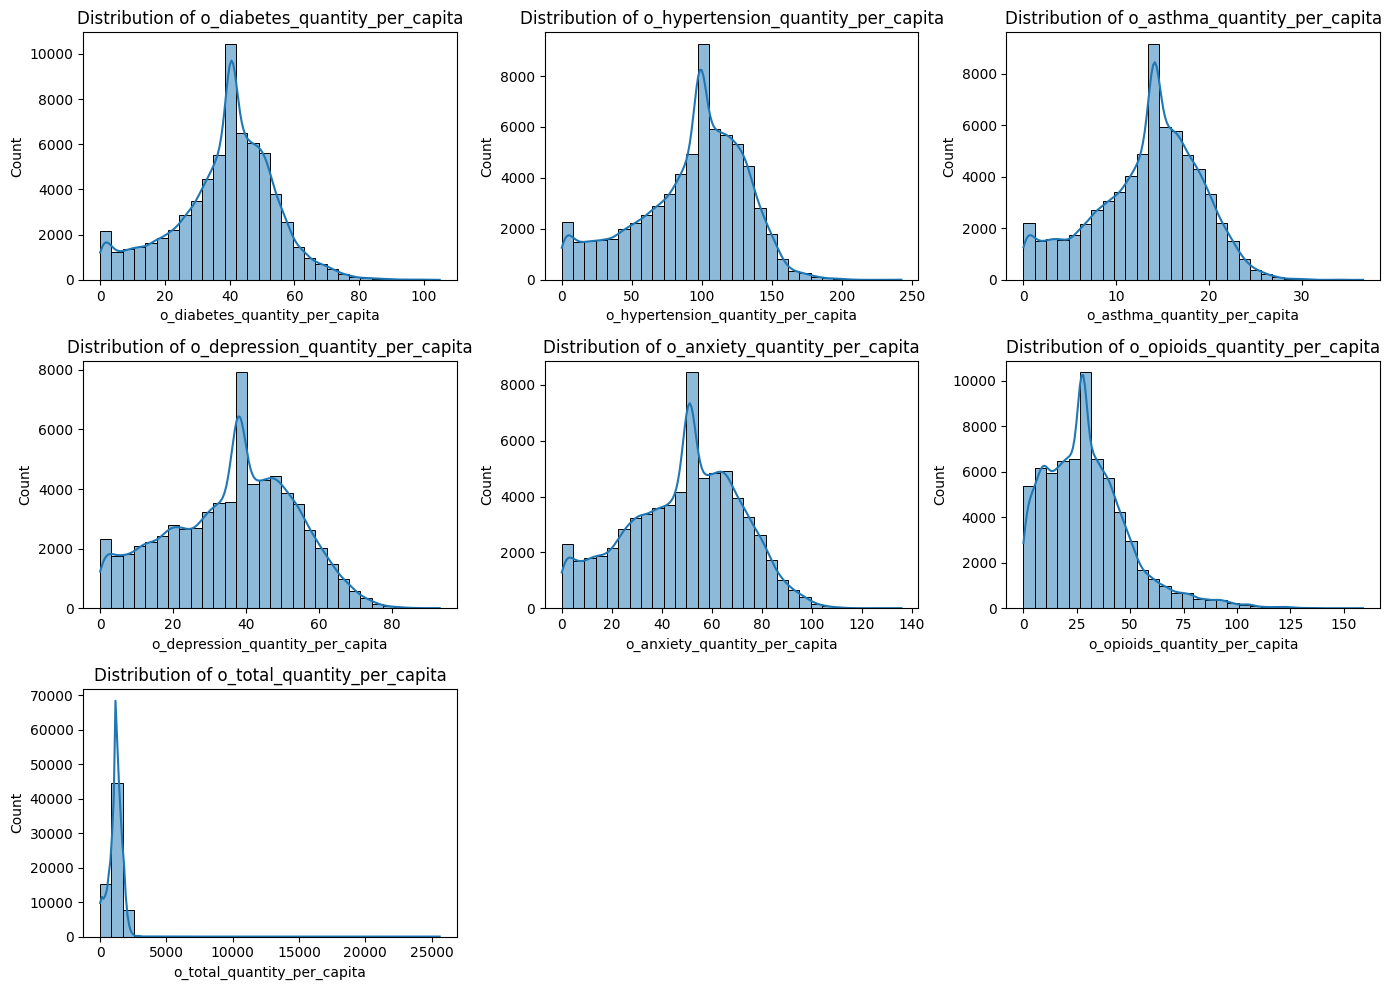

In [14]:
# Histogram Distributions for Each Outcome
import seaborn as sns

plt.figure(figsize=(14, 10))

for i, col in enumerate(medical_outcomes, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f"Distribution of {col}")

plt.tight_layout()
plt.show()

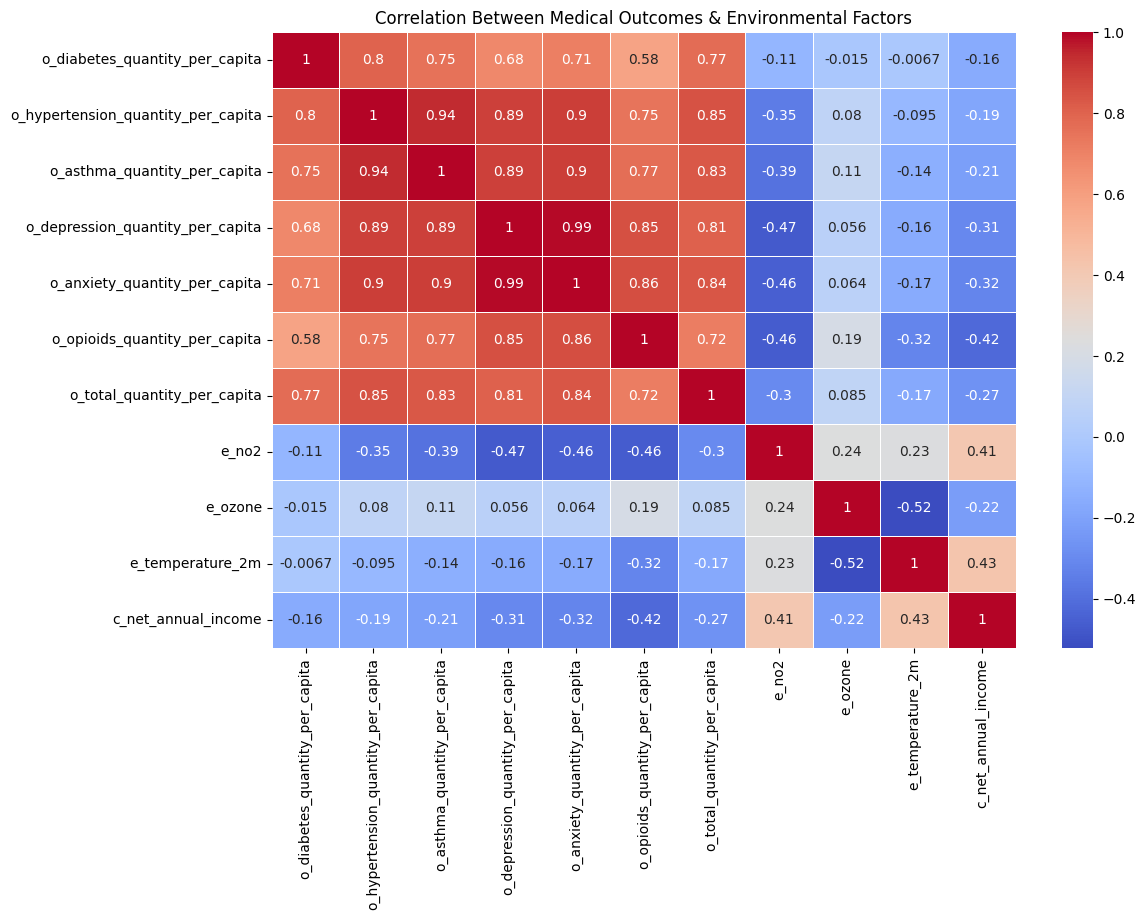

In [15]:
#  Correlation Analysis (Medical Outcomes vs Environmental Factors)
corr_features = medical_outcomes + ['e_no2', 'e_ozone', 'e_temperature_2m', 'c_net_annual_income']

plt.figure(figsize=(12, 8))
sns.heatmap(df[corr_features].corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Between Medical Outcomes & Environmental Factors")
plt.show()

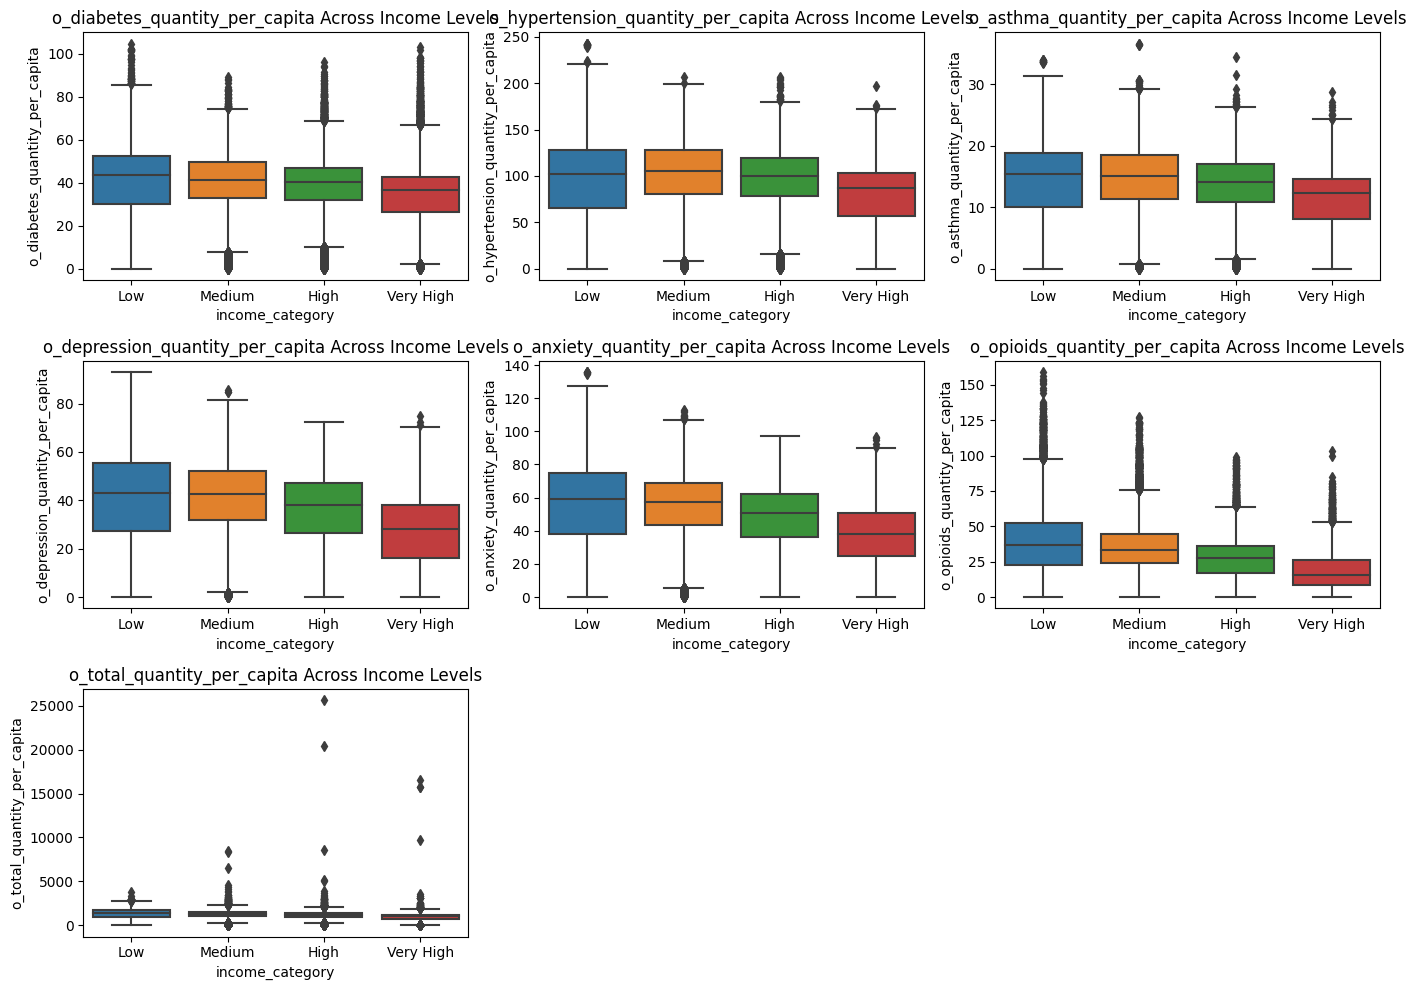

In [16]:
# Categorizing Income Levels
df['income_category'] = pd.qcut(df['c_net_annual_income'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])

# Boxplot of Disease Rates Across Income Levels
plt.figure(figsize=(14, 10))

for i, col in enumerate(medical_outcomes, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x='income_category', y=col, data=df)
    plt.title(f"{col} Across Income Levels")

plt.tight_layout()
plt.show()

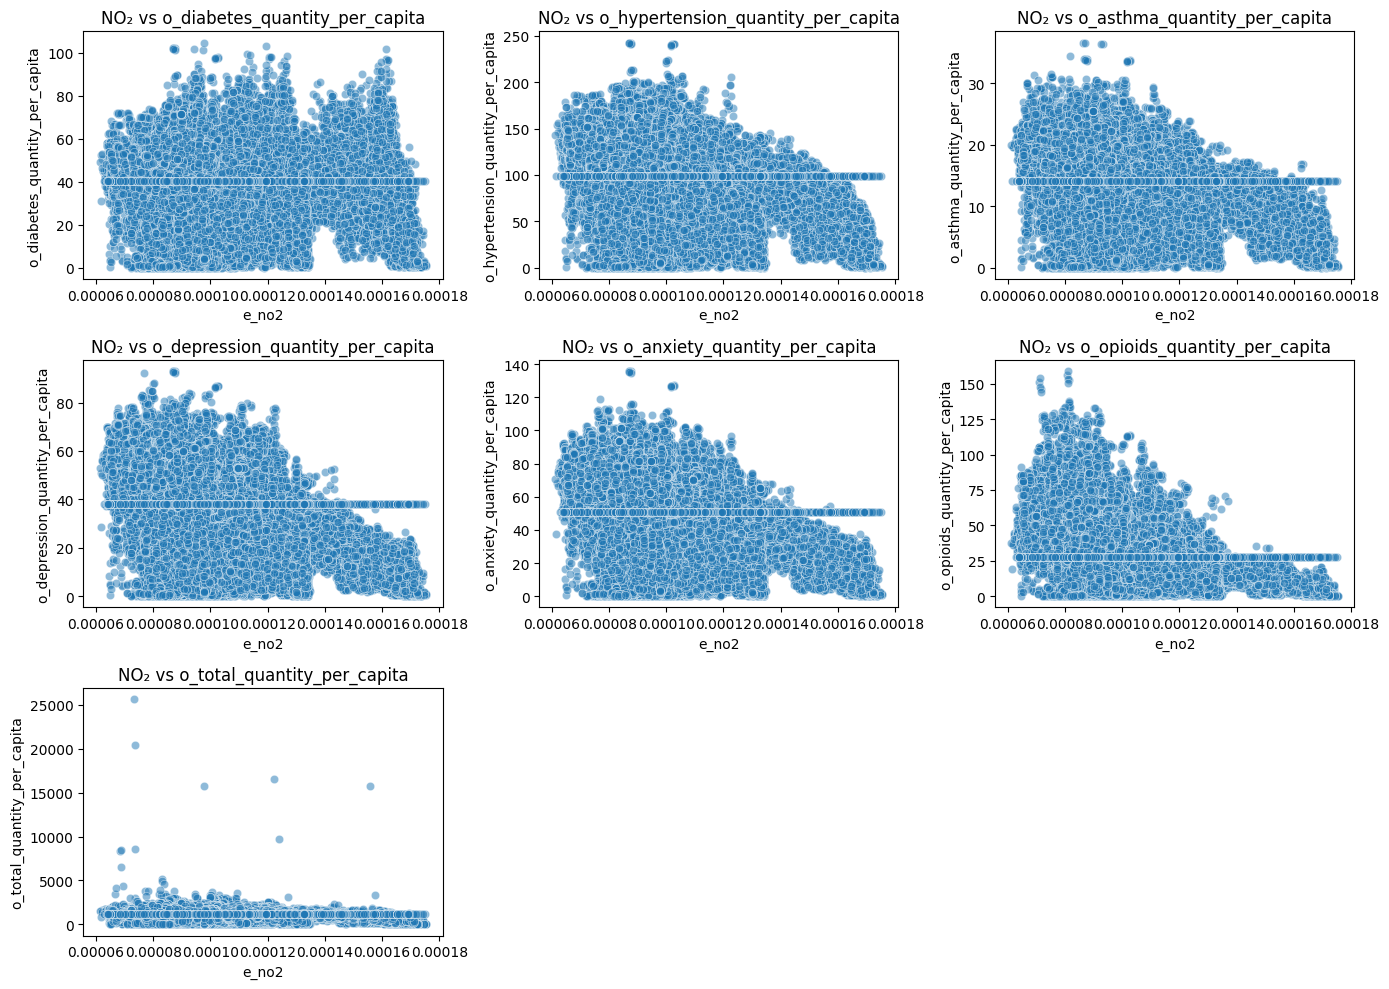

In [17]:
# Scatter Plot: NO₂ vs Each Disease Outcome
plt.figure(figsize=(14, 10))

for i, col in enumerate(medical_outcomes, 1):
    plt.subplot(3, 3, i)
    sns.scatterplot(x=df['e_no2'], y=df[col], alpha=0.5)
    plt.title(f"NO₂ vs {col}")

plt.tight_layout()
plt.show()

In [18]:

#  Identify Top 10 Regions for Each Medical Condition
for disease in medical_outcomes:
    top_regions = df[['geography_code', disease]].sort_values(by=disease, ascending=False).head(10)
    print(f"\n Top 10 Regions with Highest {disease.replace('_', ' ').title()} Rates:")
    print(top_regions)


 Top 10 Regions with Highest O Diabetes Quantity Per Capita Rates:
      geography_code  o_diabetes_quantity_per_capita
9536       E01010052                      104.837522
1310       E01001364                      103.221419
24761      E01026073                      102.251177
24762      E01026074                      102.166879
24760      E01026072                      102.099758
1310       E01001364                      101.903053
24795      E01026109                      101.848342
24789      E01026103                      101.645454
5282       E01005583                      101.631184
24790      E01026104                      101.346177

 Top 10 Regions with Highest O Hypertension Quantity Per Capita Rates:
      geography_code  o_hypertension_quantity_per_capita
24761      E01026073                          242.608098
24762      E01026074                          242.481109
24760      E01026072                          242.395279
24795      E01026109                          241

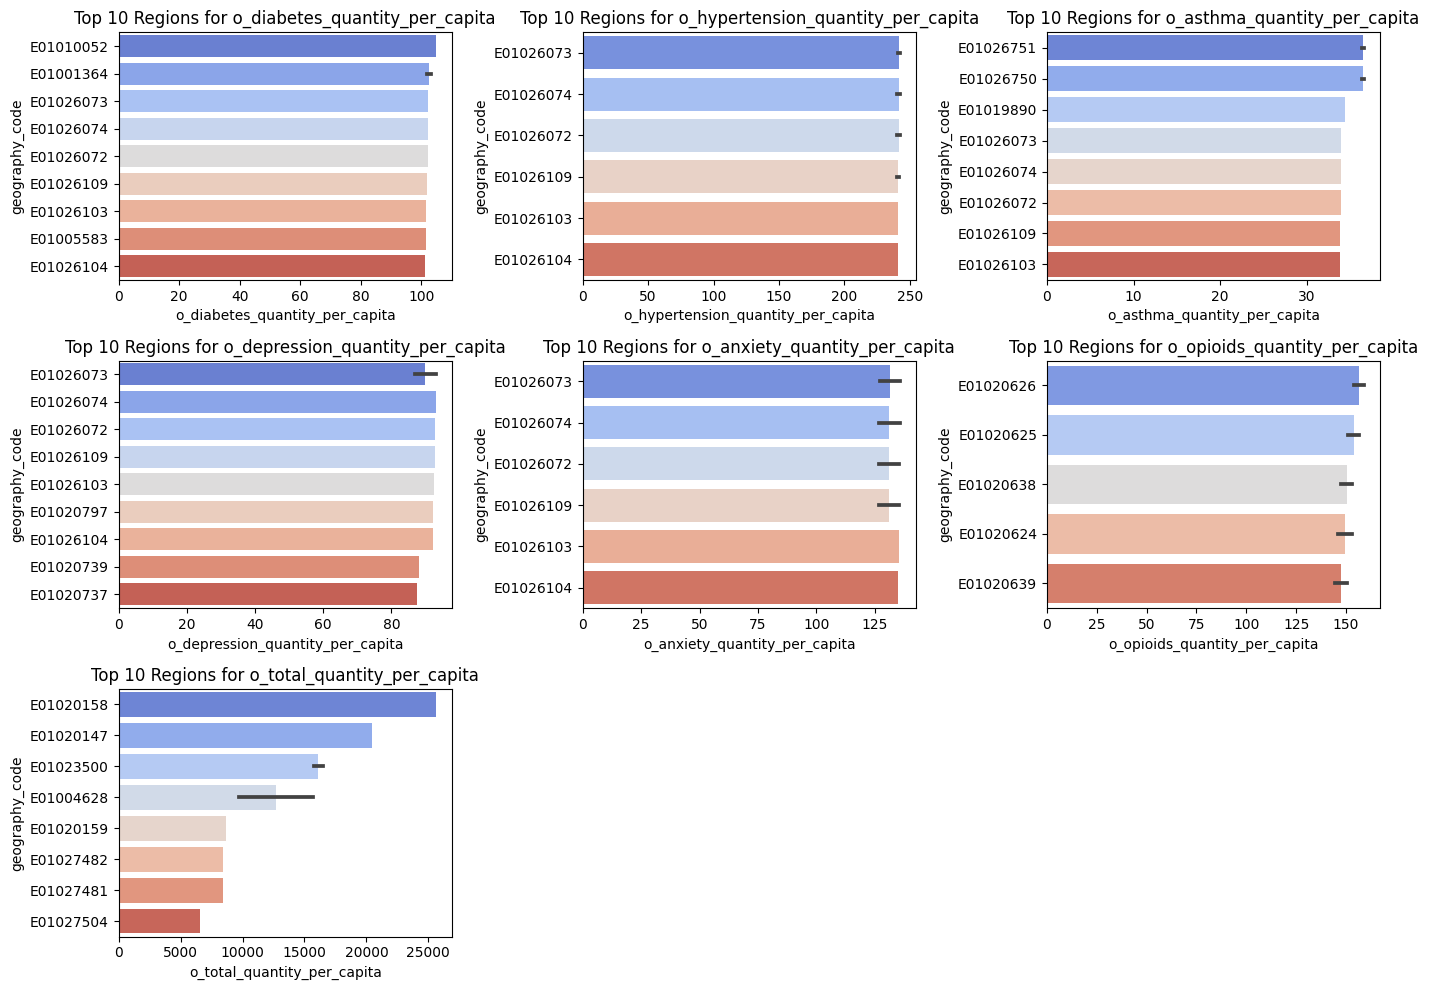

In [19]:
# Visualizing Top 10 Affected Regions Using Bar Plots
plt.figure(figsize=(14, 10))

for i, col in enumerate(medical_outcomes, 1):
    top_regions = df[['geography_code', col]].sort_values(by=col, ascending=False).head(10)
    plt.subplot(3, 3, i)
    sns.barplot(x=top_regions[col], y=top_regions['geography_code'], palette="coolwarm")
    plt.title(f"Top 10 Regions for {col}")

plt.tight_layout()
plt.show()

In [26]:
np.random.seed(42)
additional_features_to_drop=['geography_code', 'lsoa21nm', 'geometry','income_category','year']

X = df.drop(columns=medical_outcomes+additional_features_to_drop)
y = df[medical_outcomes]

In [27]:
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (67508, 158)
Shape of y: (67508, 7)


In [28]:
def apply_knockoff_filter(X, y, fdr=0.15):

    # Scale the predictors
    scaler = StandardScaler()
    predictors_scaled = scaler.fit_transform(X)
    all_selected_features=set()

    # Generate knockoffs
    sampler = kf.GaussianSampler(predictors_scaled)
    X_knockoffs = sampler.sample_knockoffs()

    # Apply knockoff filter
    knockoff_filter = KnockoffFilter(fstat='lasso')

    for outcome in y:
        selected_features = knockoff_filter.forward(
            X=predictors_scaled,
            Xk=X_knockoffs,
            y=df[outcome],
            fdr=0.15
        )

        selected_features_boolean = selected_features.astype(bool)

    # Get feature names for this outcome
        selected_feature_names = X.columns[selected_features_boolean]

    # Add to the set of all selected features
        all_selected_features.update(selected_feature_names.tolist())

    unique_selected_features = list(all_selected_features)

    return unique_selected_features, X[unique_selected_features]

In [30]:
Features_list, X_filtered = apply_knockoff_filter(X, y, fdr=0.15)
print(Features_list)
print("Shape of X_filtered:", X_filtered.shape)

['c_percent_white', 'e_evaporation_from_open_water_surfaces_excluding_oceans_sum', 'c_percent_commute_train', 'c_percent_commute_on_foot', 'e_lake_bottom_temperature', 'e_surface_latent_heat_flux_sum', 'c_percent_muslim', 'e_leaf_area_index_low_vegetation', 'e_total_precipitation_sum', 'centroid_x', 'e_lake_total_layer_temperature', 'e_surface_solar_radiation_downwards_sum', 'c_percent_divorced_or_civil_partnership_dissolved_divorced', 'e_soil_temperature_level_1', 'e_snow_albedo', 'c_percent_commute_bus', 'e_temperature_2m', 'c_percent_married_or_in_a_registered_civil_partnership_married_opposite_sex', 'c_percent_2._professional_occupations', 'e_dewpoint_temperature_2m', 'c_percent_wfh', 'c_percent_bad_health', 'e_snow_density', 'c_percent_10_years_or_more', 'e_ozone', 'c_percent_asian', 'e_surface_pressure', 'e_no2', 'c_percent_widowed_or_surviving_civil_partnership_partner_widowed', 'c_percent_unemployed', 'e_total_evaporation_sum', 'c_percent_aged_80_to_84_years', 'c_percent_tfw_le

In [32]:
def tune_xgboost(X_filtered, y, use_gpu=True):
    if use_gpu:
        try:
            gpu_check = xgb.XGBRegressor(tree_method='gpu_hist')
            print("GPU acceleration enabled for XGBoost")
        except Exception as e:
            print(f"Warning: GPU acceleration not available: {e}")
            print("Falling back to CPU mode")
            use_gpu = False

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_filtered, y, test_size=0.1, random_state=42
    )

    # Define parameter grid
    param_grid = {
        'estimator__n_estimators': [100, 200, 300, 400],
        'estimator__max_depth': [3, 5, 7, 9],
        'estimator__learning_rate': [0.01, 0.05, 0.1, 0.2],
        'estimator__subsample': [0.7, 0.8, 0.9, 1.0],
        'estimator__colsample_bytree': [0.7, 0.8, 0.9, 1.0]
    }

    # Initialize XGBoost with GPU parameters
    xgb_model = xgb.XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        tree_method='gpu_hist' if use_gpu else 'hist',  # Use GPU histogram method
        gpu_id=0 if use_gpu else None,  # Specify GPU ID (usually 0 for first GPU)
        predictor='gpu_predictor' if use_gpu else 'auto'  # Use GPU for prediction
    )
    multi_model = MultiOutputRegressor(xgb_model)

    # Perform randomized search
    random_search = RandomizedSearchCV(
        multi_model,
        param_distributions=param_grid,
        n_iter=10,
        cv=5,
        scoring='r2',
        random_state=42,
        n_jobs=-1  # Use all CPU cores for parallel processing
    )

    random_search.fit(X_train, y_train)
    # Extract best parameters (remove 'estimator__' prefix)
    best_params = {key.replace('estimator__', ''): value
                  for key, value in random_search.best_params_.items()}
    return best_params, X_train, X_test, y_train, y_test



In [33]:
#best_params, X_train, X_test, y_train, y_test = tune_xgboost(X_filtered,y)
best_params, X_train, X_test, y_train, y_test = tune_xgboost(X_filtered, y, use_gpu=True)

GPU acceleration enabled for XGBoost


In [34]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(60757, 55)
(6751, 55)
(60757, 7)
(6751, 7)


In [37]:
def create_rashomon_set(X_train, X_test, y_train, y_test, best_params, n_models=10, use_gpu=True):
    models = []
    performances = []

    for seed in range(n_models):
        base_model = xgb.XGBRegressor(
            **best_params,
            objective='reg:squarederror',
            random_state=seed,
            tree_method='gpu_hist' if use_gpu else 'hist',
            gpu_id=0 if use_gpu else None,
            predictor='gpu_predictor' if use_gpu else 'auto'
        )
        model = MultiOutputRegressor(base_model)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred, multioutput='uniform_average')  # Support multi-output
        models.append(model)
        performances.append(r2)

    performance_threshold = np.percentile(performances, 75)
    selected_models = [m for m, s in zip(models, performances) if s >= performance_threshold]

    return selected_models


In [38]:
rashomon_models = create_rashomon_set(X_train, X_test, y_train, y_test, best_params, use_gpu=True)

In [39]:
rashomon_models

[MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                             callbacks=None,
                                             colsample_bylevel=None,
                                             colsample_bynode=None,
                                             colsample_bytree=0.9, device=None,
                                             early_stopping_rounds=None,
                                             enable_categorical=False,
                                             eval_metric=None,
                                             feature_types=None, gamma=None,
                                             gpu_id=0, grow_policy=None,
                                             importance_type=None,
                                             interaction_constraints=None,
                                             learning_rate=0.1, max_bin=None,
                                             max_cat_threshold=None,


In [40]:
def variable_importance_analysis(models, X_test, y_test, y_train, feature_names, top_n=10):
    feature_scores = {
        method: pd.DataFrame(index=feature_names)
        for method in ['permutation', 'shap', 'loco', 'cmr']
    }

    for i, model in enumerate(tqdm(models, desc="Processing Rashomon models")):
        print(f"\n Evaluating model {i+1}/{len(models)}")

        #1. Permutation Importance 
        perm = permutation_importance(
            model, X_test, y_test, scoring='r2', n_repeats=10,
            random_state=42, n_jobs=-1
        )
        feature_scores['permutation'][f'model_{i}'] = perm.importances_mean

        # 2. SHAP 
        shap_total = np.zeros(len(feature_names))
        sample_X = X_test.sample(n=200, random_state=42)

        for j, single_model in enumerate(model.estimators_):
            explainer = shap.Explainer(
                single_model,
                sample_X,
                feature_perturbation="interventional"
            )
            shap_values = explainer(sample_X)
            shap_avg = np.abs(shap_values.values).mean(axis=0)
            shap_total += shap_avg

        shap_mean = shap_total / len(model.estimators_)
        feature_scores['shap'][f'model_{i}'] = shap_mean

        # 3. LOCO 
        loco_scores = []
        base_score = r2_score(y_test, model.predict(X_test), multioutput='uniform_average')

        for col in feature_names:
            X_temp = X_test.drop(columns=col)
            y_temp = y_test.copy()

            model_temp = MultiOutputRegressor(
                xgb.XGBRegressor(**model.estimators_[0].get_params())
            )
            model_temp.fit(X_temp, y_temp)
            y_pred_temp = model_temp.predict(X_temp)

            loco_score = base_score - r2_score(y_temp, y_pred_temp, multioutput='uniform_average')
            loco_scores.append(loco_score)

        feature_scores['loco'][f'model_{i}'] = loco_scores

        # 4. CMR Approximation 
        cmr_scores = []
        for col in feature_names:
            X_imputed = X_test.copy()
            X_imputed[col] = np.random.permutation(X_imputed[col])
            cmr_score = base_score - r2_score(y_test, model.predict(X_imputed), multioutput='uniform_average')
            cmr_scores.append(cmr_score)

        feature_scores['cmr'][f'model_{i}'] = cmr_scores

    # Combining all methods
    mean_ranks = pd.DataFrame(index=feature_names)

    for method, df in feature_scores.items():
        method_ranks = df.rank(ascending=False).mean(axis=1)
        mean_ranks[method] = method_ranks

    mean_ranks['mean_rank'] = mean_ranks.mean(axis=1)
    top_features = mean_ranks.sort_values('mean_rank').head(top_n)

    return top_features, mean_ranks, feature_scores


In [41]:
top_features, mean_ranks, feature_scores = variable_importance_analysis(
    models=rashomon_models,
    X_test=X_test,
    y_test=y_test,
    y_train=y_train,  
    feature_names=X_filtered.columns.tolist(),
    top_n=10
)

print("Top 10 Most Important Features:")
print(top_features)



Processing Rashomon models:   0%|          | 0/3 [00:00<?, ?it/s]


🔍 Evaluating model 1/3


Processing Rashomon models:  33%|███▎      | 1/3 [28:02<56:04, 1682.08s/it]


🔍 Evaluating model 2/3


Processing Rashomon models:  67%|██████▋   | 2/3 [56:04<28:02, 1682.48s/it]


🔍 Evaluating model 3/3


Processing Rashomon models: 100%|██████████| 3/3 [1:24:10<00:00, 1683.35s/it]

Top 10 Most Important Features:
                                                    permutation       shap  \
o_ome_per_capita                                       1.000000   1.000000   
c_percent_tfw_2km_to_5km                               7.333333   4.000000   
c_percent_wfh                                          6.000000   5.000000   
centroid_x                                             3.333333   3.000000   
c_percent_white                                        3.666667   6.666667   
centroid_y                                             2.000000   2.000000   
e_surface_pressure                                    12.333333   9.000000   
c_percent_2._professional_occupations                 10.000000  18.000000   
e_no2                                                  5.000000   8.333333   
e_evaporation_from_open_water_surfaces_excludin...    13.333333  14.000000   

                                                         loco        cmr  \
o_ome_per_capita                 